# How does human population affect forest area in developed, transitioning, and undeveloped countries?

With a graph of human population vs. forest area, we will find a line of best fit based on the quadratic model in order to fit the data as well as possible. It might be the case that another model fits better, but each will be tested. Three distinct models will be created for each country status. Because the data is averaged between numerous countries of each status, significant changes in a particular country will be accounted for. The model will likely providea satisfying explanation and allow for further interpretation of the data to predict future forest area. 

At a later point, it will be interesting to attempt to account for and predict a change in a country's status to predict overall forest area over time.

FORESTS THAT WERE PREVIOUSLY FEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEESH

TO DO LIST:
3. GET HUMAN POP DATA
4. GRAPH CSV FOREST DATA VS HUMAN POP DATA
5. COMBINE COUNTRIES BASED ON DEVELOPMENT STATUS
6. GRAPH THAT AGAINST HUMAN POPULATION

THE GOAL IS TO GET A FINAL GRAPH THAT DEMONSTRATES DEFORESTATION RATES IN RELATION TO A COUNTRY'S DEVELOPMENT STATUS

In [120]:
"""imports necessary functions from modsim and creates a pandas object"""

from modsim import *
import pandas as pd

In [124]:
"""gets initial forest data from a spreadsheet"""

data_trees = pd.read_csv("ForestP1/forest-area-as-share-of-land-area.csv", 
                   names = ['Country', 'Acronym', 'Year', 'Forest Area/Total Land'],
                   header = None)

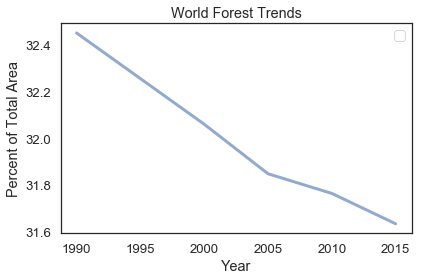

In [125]:
def condense_to_avg(data, entries_per_country):
    """
    data - table of data for various countries and years
    entries_per_country - number of data points per country
    
    This function will average the data over each year between all the countries
    and return a more manageable datafram
    """
    
    data_length = len(data['Year'])                          #stores the length of the data

    time = TimeSeries()                                      #stores the data averages 
    
    for i in range (entries_per_country):                    #assigns default state to time
        time[i] = float(0);

    num_of_countries = 0;                                    #keeps track of number of countries to make averages later

    for i in range (data_length):                            #loop tracks totals between countries each year
        num = i % entries_per_country
        
        time[num] += data['Forest Area/Total Land'][i]
        
        if (num == 0):
            num_of_countries += 1
    
    for i in range (entries_per_country):                    #finds the average for each data point
        time[i] = time[i]/num_of_countries

    averages = {'Year' : data_trees['Year'][0:entries_per_country],            #creates a new, more manageable dataframe
                'Population' : time}
        
    return averages                                          #returns new dataframe

data_avg = condense_to_avg(data,5)                           #plots and saves new dataframe

plot(data_avg['Year'], data_avg['Population'])

decorate(title = 'World Forest Trends',
         xlabel = 'Year', 
         ylabel = 'Percent of Total Area')


In [123]:
def human_v_trees(human_data, tree_data):
    """
    human_data - a dataframe containing the year vs. human population
    tree_data - a dataframe containing the year vs forest area
    both have two columns: one called 'Year' and one called 'Population'
    
    This function will return a dataframe that keeps track of human population vs forest population
    """